# Pós-graduação em Ciência da Computação - UFABC
## Projeto de Mineração de Dados - Professor Thiago Covões
### Alunos: Fernanda Borges e Thiago Rizuti

# Introdução

O objetivo do projeto é interpretar automaticamente captchas de áudio, que neste caso são áudios com quatro caracteres gravados pelos alunos separadamente e concatenados de forma aleatória em arquivos .wav.

Esta base foi crida considerando-se os seguintes caracteres: a,b,c,d,h,m,n,x,6,7. Ela contém 200 observações para o conjunto de treinamento e 147 observações para o conjunto de validação.

Primeiramente desenvolvemos classificadores capazes de distinguir cada caractere separadamente, sendo que cada caractere do captcha representa uma classe. Em seguida consideramos que para cada arquivo .wav recebido a predição é a combinação das predições individuais para cada caractere.

Para realizar este projeto foram usadas as bibliotecas:
- librosa, que é um pacote para análise de áudios e músicas; 
- pandas, que é uma ferramenta para estruturação e análise de dados;
- numpy, que é muito utilizada para computações científicas;
- matplotlib, que é utilizada principalmente para a plotagem de imagens em 2D;
- sklearn, que possui ferramentas para mineração de dados;

In [1]:
import librosa 
import librosa.display as display
import pandas as pd 
import numpy as np 
import scipy as sp 
import matplotlib.pyplot as plt 
%matplotlib inline
import os
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

Também implementamos as seguintes funções, que serão explicadas ao longo do relatório.

In [2]:
%load_ext autoreload
%autoreload 2
%aimport codigo
from codigo import read_audio, extract_features, train_model, evaluation_per_character, evaluation_per_captcha

Para fins de reprodutibilidade definimos a random seed como 42

In [3]:
seed=42

# Análise Exploratória

O primeiro desafio foi segmentar cada captcha separando o áudio referente a cada caractere. Para isso utilizamos a função load da biblioteca librosa que retorna a série temporal do áudio e a taxa de amostragem dela. Observamos os espectrogramas de alguns captchas e identificamos que eles condiziam com o processo de gravação dos áudios, pois havia uma separação visual a cada dois segundos (eixo Time) entre as oscilações mais representativas (eixo Hz).

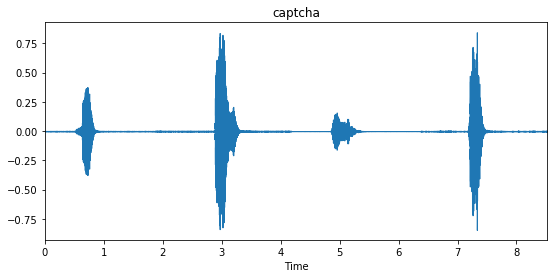

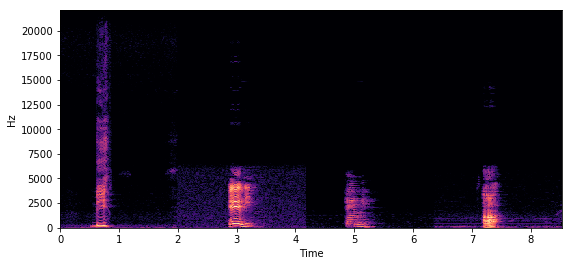

In [4]:
path = 'fase_1_corrigida/base_treinamento_I/'
signal, sampling_rate = librosa.load(os.path.join(path,'bnma.wav'), None)

plt.figure(figsize=(9, 4))
plt.title('captcha')
librosa.display.waveplot(signal, sr=sampling_rate)

X = librosa.stft(signal)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(9,4))
librosa.display.specshow(Xdb, sr=sampling_rate, x_axis='time', y_axis='hz')

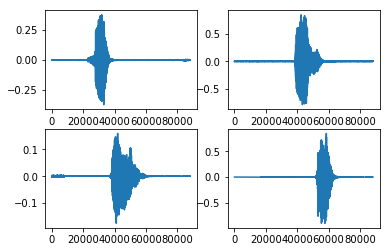

In [5]:
chars = [] 
chars += [signal[sampling_rate*2*i:sampling_rate*2*(i+1)] for i in range(4)]

fig = plt.figure()

plt.subplot(2, 2, 1)
plt.plot(chars[0])

plt.subplot(2, 2, 2)
plt.plot(chars[1])

plt.subplot(2, 2, 3)
plt.plot(chars[2])

plt.subplot(2, 2, 4)
plt.plot(chars[3])

plt.show()

Decidimos então quebrar a série temporal de cada captcha em 4 intervalo de 2 segundos.

Usamos a função read_audio para ler e dividir em caracteres as bases de treinamento e validação.

In [10]:
train_audios = read_audio('fase_1_corrigida/base_treinamento_I/')
valid_audios = read_audio('fase_1_corrigida/base_validacao_I')

print('base de treinamento: ', len(train_audios), ' captchas')
print('base de validação: ', len(valid_audios), ' captchas')

base de treinamento:  800  captchas
base de validação:  588  captchas


Para a extração das variáveis de cada caractere utilizamos o Mel Frequency Cepstral Coefficents (MFCCs) que é a ferramenta amplamente utilizada para reconhecimento automático de fala.

Os sons gerados por humanos são filtrados pelo formato do trato vocal, incluindo a língua, os dentes, etc. Este formato determina como o som é emitido. Considerando que seja possível determinar acuradamente este formato, podemos então assumir que temos uma representação acurada do fonema que está sendo reproduzido. 

O formato do trato vocal se manifesta em um envelope do espectro de força em um espaço curto de tempo, e o trabalho dos MFCCs é representar este envelope de maneira precisa.

O processamento do Mel-Frequency Cepstral Coefficients realiza primeiramente o janelamento e aplica a Transformada Discreta de Fourier (DFT). A amplitude da Transformada de Fourier é filtrada por janelas triangulares na escala Mel e então aplica-se o logaritmo. A Transformada Discreta de Cosseno é aplicada e os Coeficientes Mel-Cepstrais são as amplitudes resultantes.

Na função extract_features utilizamos a funcionalidade librosa.feature.mfcc para obter a sequência de MFCCs de cada caractere. Este processo retorna uma matriz com 20 linhas e 173 colunas por caractere. Calculamos então a média da moda, o valor mínimo, o valor máximo, a média, o desvio padrão, a mediana, a amplitude interquartil, a curtose e a assimetria por linha, alcançando 180 atributos mais a classe.

In [11]:
train_data = extract_features(train_audios,n_mfcc=20)
valid_data = extract_features(valid_audios,n_mfcc=20)

print('base de treinamento: ', train_data.shape)
print('base de validação: ', valid_data.shape)

base de treinamento:  (800, 182)
base de validação:  (588, 182)


In [12]:
train_data.head()

,char_label,captcha_label,mfcc_0_mode,mfcc_0_min,mfcc_0_max,mfcc_0_mean,mfcc_0_std,mfcc_0_median,mfcc_0_iqr,mfcc_0_kutosis,...,mfcc_18_skewness,mfcc_19_mode,mfcc_19_min,mfcc_19_max,mfcc_19_mean,mfcc_19_std,mfcc_19_median,mfcc_19_iqr,mfcc_19_kutosis,mfcc_19_skewness
0,n,nxdb,-245.487808,-491.975617,-194.686086,-417.305208,79.117426,-452.077303,99.710852,0.782509,...,-0.299771,-12.242891,-25.485782,6.123356,-8.152290,4.833608,-7.601971,5.312853,1.430341,-0.754231
1,x,nxdb,-357.421560,-715.843120,-431.073907,-631.238180,85.963913,-680.197430,150.014373,-0.906546,...,0.388549,-7.234175,-15.468350,10.702343,-2.817393,5.272377,-2.642571,7.340652,-0.508314,0.002802
2,d,nxdb,-345.359731,-691.719462,-326.739157,-587.544800,72.264324,-610.983676,38.608588,3.880415,...,-0.753904,-7.042732,-15.085463,18.776398,1.463110,5.836817,1.404677,7.192914,0.569756,0.229915
3,b,nxdb,-315.886948,-632.773896,-258.348669,-440.115750,85.000602,-416.057844,12.607385,0.418852,...,0.152348,-6.110734,-13.221468,20.565461,4.075790,4.804251,4.535909,5.962860,1.391552,-0.189926
4,c,cxxd,-149.309599,-299.619197,-81.328246,-249.629725,70.350302,-285.894262,27.974912,0.246821,...,-0.892403,-6.811772,-14.623545,2.486449,-6.271205,3.286131,-6.304521,3.750038,0.149896,-0.042438


In [13]:
valid_data.head()

,char_label,captcha_label,mfcc_0_mode,mfcc_0_min,mfcc_0_max,mfcc_0_mean,mfcc_0_std,mfcc_0_median,mfcc_0_iqr,mfcc_0_kutosis,...,mfcc_18_skewness,mfcc_19_mode,mfcc_19_min,mfcc_19_max,mfcc_19_mean,mfcc_19_std,mfcc_19_median,mfcc_19_iqr,mfcc_19_kutosis,mfcc_19_skewness
0,m,mxac,-334.081487,-669.162975,-314.176925,-603.075554,103.130460,-654.616340,42.667608,1.385912,...,-0.147157,-3.679888,-8.359776,16.655460,3.626932,4.178960,3.625000,5.633111,0.308025,-0.004869
1,x,mxac,-330.590784,-662.181568,-281.832139,-392.109255,49.983467,-415.822559,61.863531,4.209920,...,0.080754,-2.629972,-6.259945,14.540932,5.357747,3.755165,5.776191,4.492333,0.207635,-0.445116
2,a,mxac,-243.220526,-487.441052,-276.956232,-446.257232,53.596527,-472.763804,53.764714,2.684707,...,-0.688030,-5.689484,-12.378968,14.851284,5.103265,5.291714,6.252033,6.067117,1.360532,-1.138028
3,c,mxac,-318.300143,-637.600285,-304.067812,-513.072393,99.774090,-552.096535,133.189221,-0.730332,...,-0.788111,-2.488597,-5.977194,13.710351,3.648911,4.215219,3.833991,6.162002,-0.649346,0.061564
4,m,mcx7,-283.773539,-568.547079,-253.296771,-483.305111,84.566207,-514.342071,59.786139,1.052818,...,0.143677,-3.992957,-8.985913,17.004147,2.526364,4.959011,2.280127,6.566428,0.005446,0.323822


#  Metodologia

Depois de extrair as variáveis adotamos a mesma abordagem de quando se lida com um problema de classificação tradicional.

Nós utilizamos o GridSearchCV do sklearn para comparar diferentes modelos e configurações de hiperparâmetros. 

Definimos a validação cruzada, de modo que o conjunto de dados de treino disponibilizado pelo professor fosse utilizado para treino e o conjunto de dados de validação fosse utilizado para calcular a métrica de avaliação (acurácia). 
Executamos o grid search uma vez para cada um dos modelos com cada uma das diferentes combinações de hiperparâmetros , calculando assim a acurácia na base de validação. 
Desta maneira foi possível escolher o melhor modelo com a melhor combinação de parâmetros selecionando o maior best_score.

Os modelos testados foram: 
- Gaussian Naive Bayes (hiperparâmetros: nenhum)
- k-nearest neighbors (hiperparâmetros: número de vizinhos, votação uniforme ou ponderada pela distância, distâncias de manhattan e euclidiana)
- Regressão Logística (peso da regularização, regularizão l1 e l2)
- Árvore de Decisão (profundidade máxima)
- Random Forest (profundidade máxima e número de árvores.

Antes de treinar os modelos, usamos também o StandardScaler do sklearn para normalizar os dados com z-score.

In [14]:
transformer = StandardScaler()

estimators = [GaussianNB(),KNeighborsClassifier(),LogisticRegression(),
              DecisionTreeClassifier(),RandomForestClassifier()]
    
param_grids = [{},
           {'n_neighbors':[2,5,7,10,12], 'weights':['uniform','distance'],'p':[1,2]},
           {'C':np.logspace(-4,4,9),'penalty':['l1','l2'],'random_state':[seed]},
           {'max_depth':np.linspace(2,15,20),'random_state':[seed]},
           {'max_depth':np.linspace(2,15,20),'n_estimators':[50],'random_state':[seed]}]

metric = 'accuracy'

A metodologia descrita foi toda implementada na função train_model. 
A função recebe os dados de treinamento e validação, a lista de modelos, lista de hiperparâmetros, , o normalizador e a métrica a ser utilizada. Retornando o normalizador ajustado , o melhor modelo treinado e uma tabela de resultados do gridsearch.

In [15]:
transformer, best_model, results = train_model(train_data,valid_data,transformer,estimators,
                                               param_grids,metric)

#  Resultados

A tabela abaixo mostra os resultados do gridsearch. Observamos que a RegressãoLogística foi a que obteve melhor resultado no conjunto de validação, sendo este escolhido como o melhor modelo. Porém observando a elevada métrica no conjunto de treinamento em comparação ao de validação, podemos concluir que o modelo sofre com um problema de overfitting.

In [16]:
pd.DataFrame(results).sort_values(by='validation metric',ascending=False).reset_index(drop=True)

,estimator,training metric,validation metric
0,LogisticRegression,0.9600,0.789116
1,KNeighborsClassifier,1.0000,0.770408
2,RandomForestClassifier,1.0000,0.751701
3,GaussianNB,0.6700,0.544218
4,DecisionTreeClassifier,0.9425,0.506803


O melhor valor de regularização escolhido foi 1, isto é, um modelo sem regularização.

In [17]:
print(best_model)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)


Implementamos a função evaluate_by_character para avaliar com mais detalhes o melhor modelo 
escolhido. A função calcula a matriz de confusão, precision, recall, e f1 para cada classe

In [18]:
metrics, conf = evaluation_per_character(transformer,best_model,valid_data)

In [19]:
print(metrics)

             precision    recall  f1-score   support

          6       0.83      0.77      0.80        65
          7       0.80      0.90      0.85        61
          a       1.00      0.94      0.97        62
          b       0.59      0.86      0.70        58
          c       0.78      0.72      0.75        69
          d       0.70      0.44      0.54        48
          h       0.96      0.96      0.96        70
          m       0.69      0.60      0.64        62
          n       0.67      0.72      0.69        47
          x       0.89      0.91      0.90        46

avg / total       0.80      0.79      0.79       588



In [20]:
conf

,m,x,a,c,7,n,6,b,h,d
m,37,0,0,0,1,15,0,5,1,3
x,0,42,0,0,0,0,4,0,0,0
a,0,0,58,0,2,0,0,1,1,0
c,2,1,0,50,10,0,3,3,0,0
7,1,2,0,1,55,0,2,0,0,0
n,11,0,0,0,0,34,0,1,0,1
6,1,2,0,10,0,0,50,2,0,0
b,1,0,0,0,0,2,0,50,0,5
h,0,0,0,2,1,0,0,0,67,0
d,1,0,0,1,0,0,1,23,1,21


In [86]:
evaluation_per_captcha(transformer,best_model,valid_data)

0.40816326530612246

# Comentários Finais
Descreva os principais resultados obtidos e comente sobre: (i) dificuldades encontradas;
(ii) ideias que n˜ao foram exploradas e raz˜oes; N˜ao esquecer de enviar
junto ao relat´orio o script (de preferˆencia R/Python) que executa
os experimentos na base de dados e gera os resultados apresentados
aqui.

# Referências

http://www.practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/

http://abricom.org.br/wp-content/uploads/2016/03/bricsccicbic2013_submission_55.pdf

https://librosa.github.io/librosa/index.html

http://scikit-learn.org/stable/modules/classes.html
